## SETUP

In [1]:
import numpy as np
import os
import io
import torch
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from transformers import AutoTokenizer, AutoModel
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import random
import requests
from pathlib import Path
from tqdm.auto import tqdm
import glob
from datasets import load_dataset

c:\Users\thanh\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Authorize into HuggingFace

In [2]:
load_dotenv()

HF_TOKEN = os.environ["HF_TOKEN"]

### Hàm cần thiết

In [3]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD),
    ])

    return transform

In [4]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height

    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)

        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio

    return best_ratio

In [5]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num
    )

    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size
    )

    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    resized_img = image.resize((target_width, target_height))
    processed_images = []

    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size,
        )

        split_img = resized_img.crop(box)
        processed_images.append(split_img)

    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)

    return processed_images


In [6]:
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [7]:
def load_image_url(image_url, input_size=448, max_num=12):
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

## Load the model and tokenizer

In [8]:
model_name = "5CD-AI/Vintern-1B-v3_5"

try:
    model = AutoModel.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        use_flash_attn=False,
    ).eval().cuda()
except:
    model = AutoModel.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        trust_remote_code=True,
    ).eval().cuda()

c:\Users\thanh\AppData\Local\Programs\Python\Python313\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remode_code=True,
    use_fast=False,
)

### Test

In [10]:
generation_config = dict(
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3,
    repetition_penalty=2.5
)

prompt = "<image>\nTrích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt."

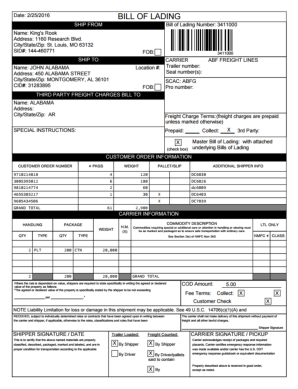

Token indices sequence length is longer than the specified maximum sequence length for this model (3407 > 1700). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: # Bill of Lading

**Ngày:** 2/25/2016

**Ship From:**
* **Tên:** King's Rock
* **Địa chỉ:** 1160 Research Blvd., St. Louis, MO 63132
* **Số ID:** 144-460771

**Ship To:**
* **Tên:** JOHN ALABAMA
* **Địa chỉ:** 450 ALABAMA STREET, MONTGOMERY, AL 36101
* **Số ID:** 31283895

**Phương thức vận chuyển:** Third Party Freight Charges Bill to

**Các thông tin khác:**
* **Mã vận chuyển:** 3411000
* **Trạm giao hàng:** ABF FREIGHT LINES
* **Tổng phí vận chuyển:** 61 USD
* **Thông tin khách hàng:** (Chưa điền)
* **Thời gian chuẩn bị:** (Chưa điền)
* **Lưu ý:** Giảm giá tùy thuộc vào giá trị và các điều kiện đã ký kết trước khi vận chuyển.
* **Chi phí vận chuyển:** (Chưa điền)
* **Giấy chứng nhận vận chuyển:** (Chưa điền)


In [11]:
test_image = "test.png"

pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()

image = Image.open(test_image).convert('RGB')
plt.imshow(image)
plt.axis("off")
plt.show()

response = model.chat(tokenizer, pixel_values, prompt, generation_config)

print(f"User: {prompt}\nAssistant: {response}")

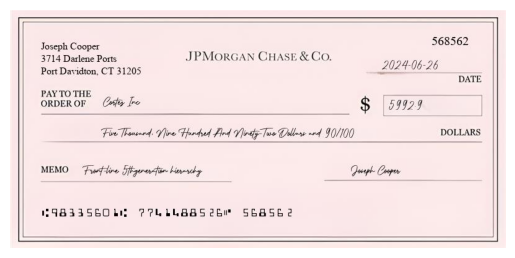

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: # Phiếu thanh toán JPMorgan Chase & Co.

**Thông tin cá nhân:**
* **Tên:** Joseph Cooper
* **Địa chỉ:** 3714 Darlene Ports, Port Davidson, CT 31205

**Thông tin giao dịch:**
* **Số phiếu:** 568562
* **Ngày:** 2024-06-26
* **Mã số:** 59929
* **Tổng cộng:** 5.992.9 USD
* **Nội dung ghi chú:** Front-line 5thgeneration heirarchy
* **Ghi chú khác:** Joseph Cooper


In [12]:
image_url = "https://datasets-server.huggingface.co/cached-assets/07kamal03/cheque_dataset_bank/--/ef83fd1d558ff37f4b4f221681d06696743b118c/--/default/train/0/image/image.jpg?Expires=1746875526&Signature=kgVp9TdQavjV88crMQC4XHQmmq70LbzpCLq4VrwKTGWMDAdtC8n36UydPaWvMyCOysTXdFriIJe9c~qXP9rh5p1X5m0OWQ3W-ao83vfx8OvLTejK4ymsgCcJqWA4fdjliLUXhTvPw1sNnKxWvenpZBCrDpCwhgiz-CIIK6LpX6SjmriePzESonKMBRLjPpSXfL7p4fQPPgD1AnOB6C5k~F9BY198-LNiwZHNNkSB9uXmRQ7w7OmYaCilRHl26dWtghr3s0MWazRFBF0U659E4VKfY3Ids7UAhU6K5zQhT80h8NbHhGd7~Ccei6eFgvoUwg91~S-rbPYeOEI2Md11OQ__&Key-Pair-Id=K3EI6M078Z3AC3"

pixel_values = load_image_url(image_url, max_num=6).to(torch.bfloat16).cuda()

test_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
plt.imshow(test_image)
plt.axis("off")
plt.show()

response = model.chat(tokenizer, pixel_values, prompt, generation_config)

print(f"User: {prompt}\nAssistant: {response}")

## Create dataset

In [13]:
cheque_data = load_dataset(
    "aniketVerma07/handwritten_cheque_vqa_dataset",
    split="train",
    trust_remote_code=True,
)

cheque_data

Dataset({
    features: ['image', 'query', 'answers'],
    num_rows: 3000
})

Ảnh trước khi chuẩn hóa


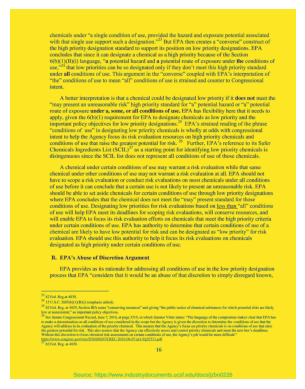

Ảnh sau khi chuẩn hóa


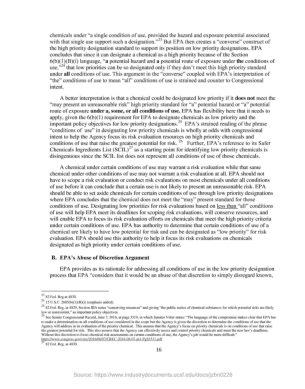

In [14]:
print("Ảnh trước khi chuẩn hóa")
plt.imshow(cheque_data[0]["image"])
plt.axis("off")
plt.show()

print("Ảnh sau khi chuẩn hóa")
image = cheque_data[0]["image"].convert('RGB')
plt.imshow(image)
plt.axis("off")
plt.show()

In [15]:
folder = Path("data")

if not os.path.exists(folder):
    folder.mkdir(parents=True, exist_ok=True)

    for i, image in enumerate(tqdm(cheque_data["image"])):
        image = image.convert('RGB')
        image.save(folder / f"{i + 1}.jpg")

### Shuffle files

In [16]:
files = glob.glob("data/*.jpg")
random.shuffle(files)

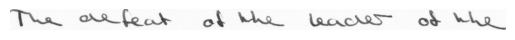

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: The effect of the leader on the


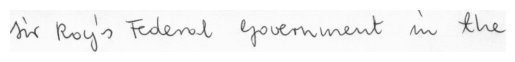

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: The text in the image appears to be a misspelling or incomplete sentence. It reads: "Sir Roy's Federal Government in the"


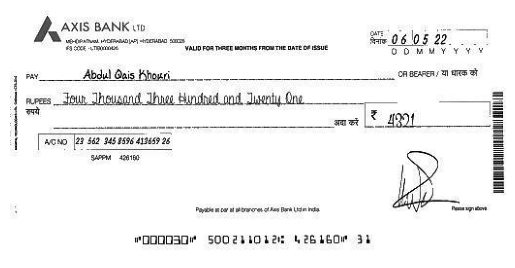

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: # Phiếu thanh toán của AXIS BANK LTD

**Thông tin người nhận:**
* Tên: Abdul Qais Khoori
* Số tiền: ₹ 4321 (Rupees)

**Thông tin tài khoản:**
* Số tài khoản: 23 562 345 8956 413659 26
* Mã số giao dịch (A/C NO): 429150
* Số dư: 500211012, 426160, 31

**Thông tin khác:**
* Ngày lập phiếu: 06/05/22
* Thời hạn sử dụng: 3 tháng
* Có chữ ký xác nhận.


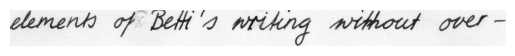

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: ## Tóm tắt thông tin từ hình ảnh:

Hình ảnh hiển thị một đoạn văn bản viết tay bằng tiếng Anh.  Nội dung chính xoay quanh việc đề cập đến các yếu tố cần thiết để đạt được thành công, cụ thể là "elements of Betty's winning without over-".  Dòng chữ này có vẻ như là một phần của bài viết hoặc tài liệu nào đó liên quan đến chiến lược hoặc kế hoạch.

**Thông tin chi tiết:**

* **Nội dung chính:**  Đoạn văn nói về những yếu tố cần thiết để đạt được thành công.
* **Cụm từ chính:** "elements of Betty's winning without over-", cho thấy đây là một phần của bài viết hoặc tài liệu liên quan đến chiến lược hoặc kế hoạch.
* **Ngôn ngữ:** Tiếng Anh


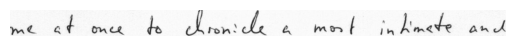

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: The text in the image appears to be a misspelling or incomplete sentence. It reads: "Me at once to chronicle a most infinite and."


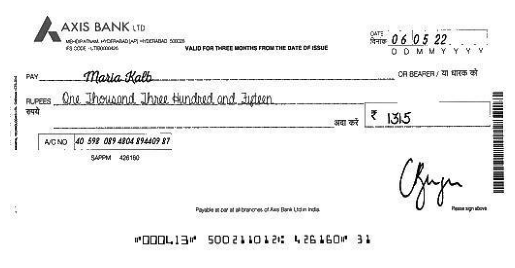

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: # Phiếu giao dịch của AXIS BANK LTD

**Thông tin chung:**
* **Ngày phát hành:** 06/05/22
* **Người nhận:** Maria Kalb
* **Loại tiền tệ:** Rupees (₹)
* **Số tiền:** 1315 Rupees
* **Mã số tài khoản:** 40 598 089 4804 894409 87
* **Số dư:** 426160 Rupees
* **Chữ ký:** Có chữ ký của nhân viên ngân hàng.

**Thông tin chi tiết:**
* Phiếu giao dịch được cấp bởi AXIS BANK LTD.
* Phiếu giao dịch có mã số A/C NO: 40 598 089 4804 894409 87 và SPPM: 426160.
* Số tiền giao dịch là 1315 Rupees.


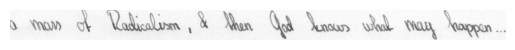

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: The text in the image appears to be a misspelling or incomplete sentence. It reads: "a man of Radicalism, it then gave reasons what may happen ...."


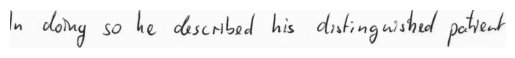

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: In doing so he described his distinguished patient


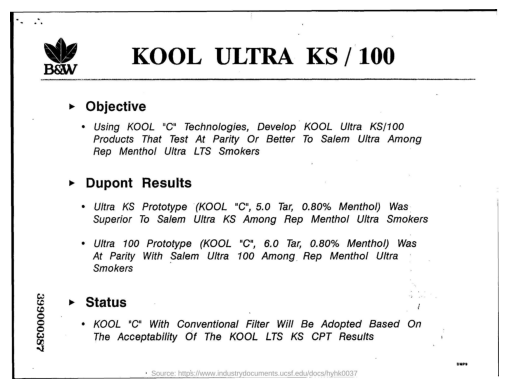

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: # Kool Ultra KS/100

**Objective:**

* Using KOOL "C" technologies, develop KOOL Ultra KS/100 products that test at parity or better to Salem Ultra among Rep Menthol Ultra smokers.

**Dupont Results:**

* Ultra KS Prototype (KOOL "C", 5.0 Tar, 0.80% Menthol) was superior to Salem Ultra KS Among Rep Menthol Ultra Smokers.
* Ultra 100 Prototype (KOOL "C", 6.0 Tar, 0.80% Menthol) was at parity with Salem Ultra 100 among Rep Menthol Ultra Smokers.

**Status:**

* KOOL "C" will be adopted based on the acceptability of the KOOL LTS KS CPT results.


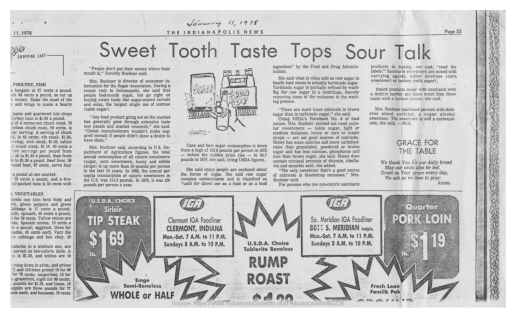

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin trong ảnh trả về dạng markdown bằng Tiếng Việt.
Assistant: # Thông tin trích xuất từ hình ảnh tạp chí The Indianapolis News ngày 11 tháng 11 năm 1978

Hình ảnh là một phần của tạp chí The Indianapolis News, với tiêu đề "Sweet Tooth Taste Tops Sour Talk Talk".  Nội dung chính xoay quanh các vấn đề về sức khỏe và đồ uống:

**Phần 1: Sức Khỏe (Poultry, Fish, Turkey):**
* Người phụ nữ trong bài viết cho rằng người dân không tiết kiệm tiền khi mua đồ uống.
* Bà ấy chỉ ra rằng có nhiều loại đồ uống kém chất lượng hơn so với những thứ tốt hơn.

**Phần 2: Đồ uống (Sugarcane, Cereals, Honey):**
* Bà ấy nói rằng tất cả các loại đồ uống được bán trên thị trường đều trải qua các thử nghiệm kỹ thuật để đảm bảo chất lượng.
* Bà ấy cho rằng cacao và bắp ngô là những loại thực phẩm giàu chất dinh dưỡng nhất thế giới.
* Bà ấy nhấn mạnh sự khác biệt đáng kể về hàm lượng calo giữa các loại đường như turbinado, glucosea, sucralose, maltodextrin, dextrose, xylitol, lactos

In [17]:
test_files = files[:10]

for image in test_files:
    plt.imshow(Image.open(image))
    plt.axis("off")
    plt.show()

    pixel_values = load_image(image, max_num=6).to(torch.bfloat16).cuda()

    response = model.chat(tokenizer, pixel_values, prompt, generation_config)

    print(f"User: {prompt}\nAssistant: {response}")
    print("=" * 40)